In [1]:
import random
import re
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import nltk
import kagglehub
import textwrap
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
)

# 1. Dataset Preparation


In [2]:
path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

Path to dataset files: /home/cici/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [3]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df = df.dropna()

In [6]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


# 2. Dataset Analysis


## 2.1. Exploratory Data Analysis (EDA)


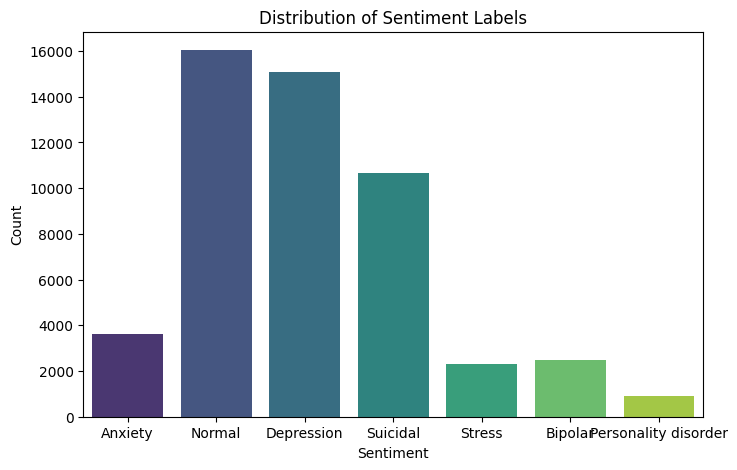

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [8]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

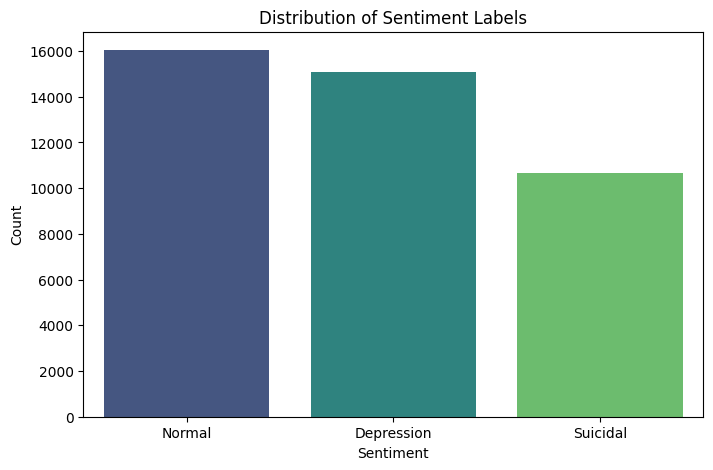

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

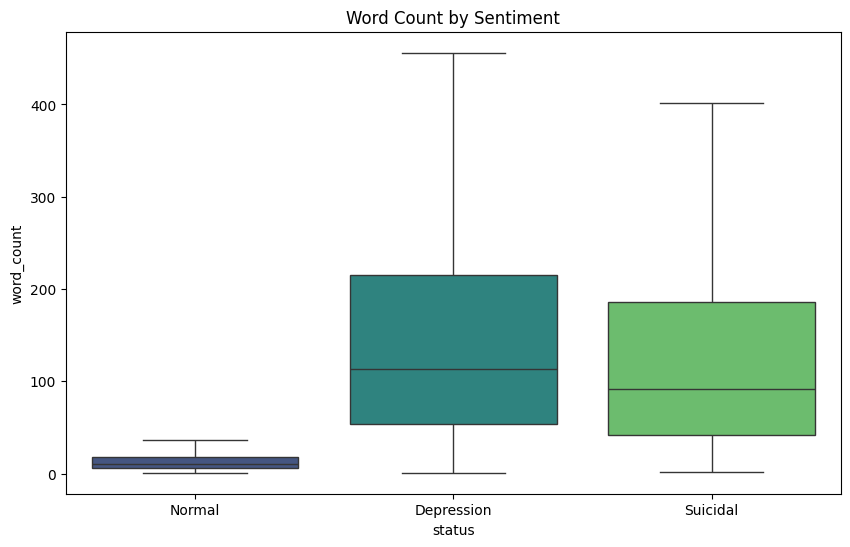

In [10]:
df["word_count"] = df["statement"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="status",
    y="word_count",
    data=df,
    hue="status",
    palette="viridis",
    legend=False,
    showfliers=False,
)
plt.title("Word Count by Sentiment")
plt.show()

## 2.2. Manual Analysis for Some Samples


# 3. Dataset Preprocessing


In [11]:
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess(text):
    # 1. Cleaning
    text = str(text).encode("ascii", "ignore").decode()
    text = re.sub(r"https?:\/\/\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = text.lower()

    # 2. Tokenization
    pattern = r"\w+(?:'\w+)?|[^\w\s]+"
    tokens = re.findall(pattern, text)

    # 3. Batch POS Tagging (Faster than tagging word-by-word)
    tagged_tokens = nltk.pos_tag(tokens)

    # 4. Lemmatization with POS context
    clean_tokens = []
    for word, tag in tagged_tokens:
        if re.match(r"\w+", word):
            pos = get_wordnet_pos(tag)
            clean_tokens.append(lemmatizer.lemmatize(word, pos))
        else:
            clean_tokens.append(word)

    return " ".join(clean_tokens)


df["statement_processed"] = df["statement"].apply(preprocess)

[nltk_data] Downloading package wordnet to /home/cici/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/cici/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [12]:
random.seed(123)

sample_indices = random.sample(range(len(df)), 6)
df_sample = df.iloc[sample_indices]

print(f"{'Original'} | {'Processed'}")
print("-" * 105)

for _, row in df_sample.iterrows():
    orig = row["statement"]
    proc = row["statement_processed"]

    print(f"{orig} | {proc}")

Original | Processed
---------------------------------------------------------------------------------------------------------
Guys can you check my pin '‰ðŸ »ðŸ'ˆðŸ »ðŸ¥º | guy can you check my pin ' '
i genuinely feel as if were living the end of the world. it feels like nothing will ever get better. the world is so fucking depressing and cruel, that i see no other solution than to just go out on my own terms rather than die a more painful death. i do not even know where I am going with this. the world is fucked beyond belief and i just want to die how are people able to find hope right now? | i genuinely feel a if be live the end of the world . it feel like nothing will ever get good . the world be so fucking depressing and cruel , that i see no other solution than to just go out on my own term rather than die a more painful death . i do not even know where i be go with this . the world be fuck beyond belief and i just want to die how be people able to find hope right now ?
Yeayy ye

In [13]:
def top_words_per_class(
    df, text_col="statement_processed", label_col="status", top_k=20
):
    unique_statuses = df[label_col].unique()

    top_words_dict = {}

    for status in unique_statuses:
        subset = df[df[label_col] == status][text_col]

        vec = CountVectorizer(ngram_range=(1, 1)).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        top_words_dict[status] = [word for word, freq in words_freq]

    comparison_df = pd.DataFrame(top_words_dict)
    return comparison_df


top_words_df = top_words_per_class(df)
print(top_words_df)

   Normal Depression Suicidal
0      be         be       be
1      to         to       to
2     the        and      and
3     and        the       my
4      it         my      the
5     you       have     have
6      my         it      not
7    have         do       do
8      of        not       it
9    that         of       me
10     in         me       of
11    for       that     that
12     do         in       in
13     me        but      but
14    but        for     just
15   this       just      for
16   with       feel     want
17     on       this     this
18     so         so       so
19    not       like     feel


In [14]:
custom_stop_words = [
    "to",
    "the",
    "and",
    "of",
    "in",
    "for",
    "with",
    "on",
    "that",
    "this",
    "it",
    "is",
    "be",
    "wa",
    "so",
    "but",
    "or",
    "as",
    "at",
    "by",
]


def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [t for t in tokens if t not in custom_stop_words]
    return " ".join(filtered_tokens)


df["statement_processed"] = df["statement_processed"].apply(remove_stop_words)

print(df[["status", "statement_processed"]].head())

   status                                statement_processed
0  Normal              gr gr dreaming ex crush my game , god
1  Normal                                 wkwkwk what a joke
2  Normal  leaf also standby front pc ... because office ...
3  Normal     thank god even though it's just a ride through
4  Normal  wed teaser concept use song day6 - only , soun...


In [15]:
random.seed(123)

sample_indices = random.sample(range(len(df)), 6)
df_sample = df.iloc[sample_indices]

print(f"{'Stop words removed'}")
print("-" * 55)

for _, row in df_sample.iterrows():
    proc = row["statement_processed"]

    print(f"{proc}")

Stop words removed
-------------------------------------------------------
guy can you check my pin ' '
i genuinely feel a if live end world . feel like nothing will ever get good . world fucking depressing cruel , i see no other solution than just go out my own term rather than die a more painful death . i do not even know where i go . world fuck beyond belief i just want die how people able find hope right now ?
yeayy yeayyy i can buy one piece clothes !! muahahahahahaha
she's super neurotic would a project ** ** a place my aunt stay . she's pretty much helpless her own . she's 53 have live my grandma basically all her life . once my grandma's mind start go , tax suddenly weren't get pay , why happen .
something i think about everyday . how much good thing would have if i not me , if i someone else , someone more . i never want life , bear into world . i a terrible , god awful fuck person , i deserve every bad fucking come my way . when those bad thing inevitably come my way , i remi

In [16]:
def ngram_comparison(df, status_label, text_col="statement_processed", top_k=10):
    subset = df[df["status"] == status_label][text_col]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4)

    n_ranges = [(1, 1), (2, 2), (3, 3)]
    titles = ["Unigrams", "Bigrams", "Trigrams"]
    colors = ["#4A90E2", "#50E3C2", "#F5A623"]

    for i, (n_range, title, color) in enumerate(zip(n_ranges, titles, colors)):
        vec = CountVectorizer(ngram_range=n_range, stop_words=None).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        if words_freq:
            words, counts = zip(*words_freq)
            sns.barplot(x=list(counts), y=list(words), ax=axes[i], color=color)
            axes[i].set_title(f"{status_label.upper()}: {title}")
            axes[i].set_xlabel("Frequency")

    plt.show()

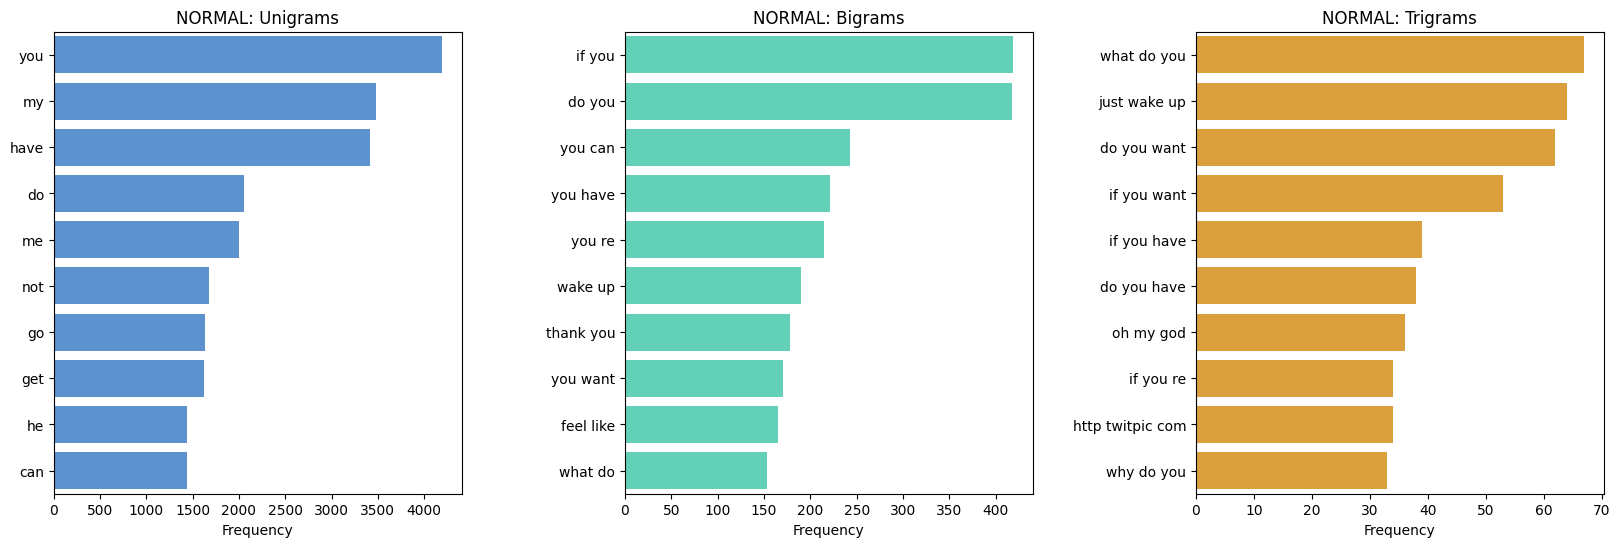

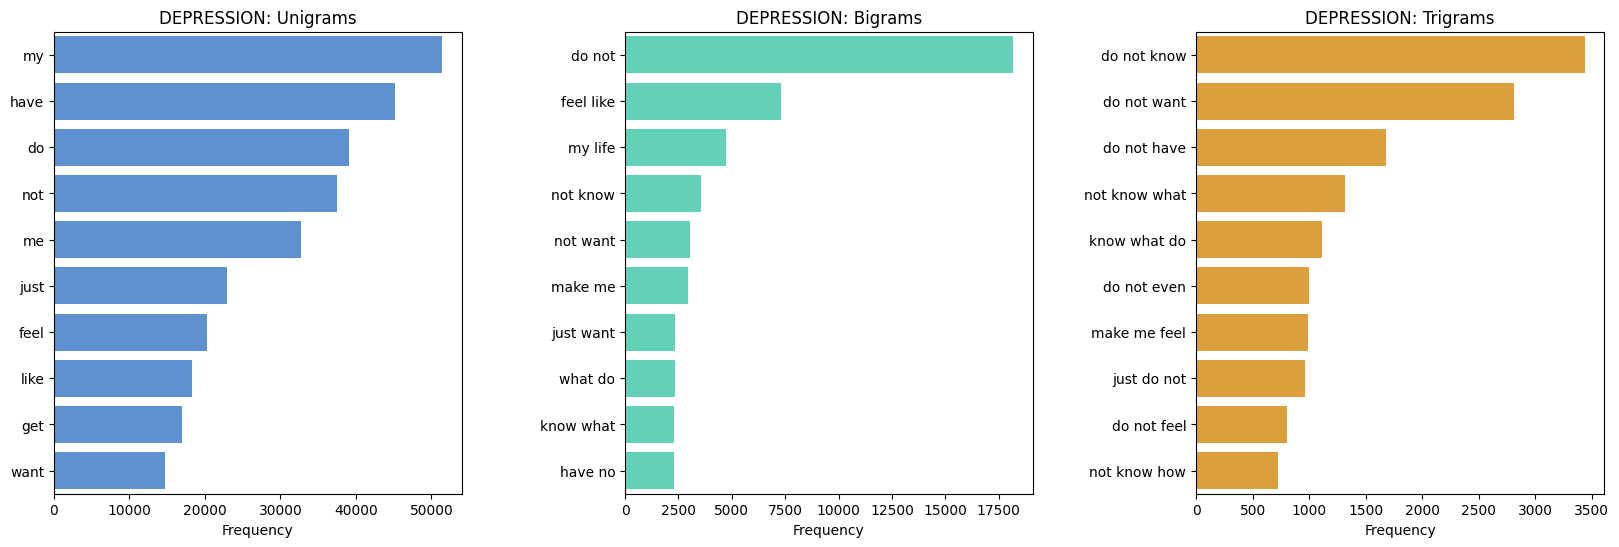

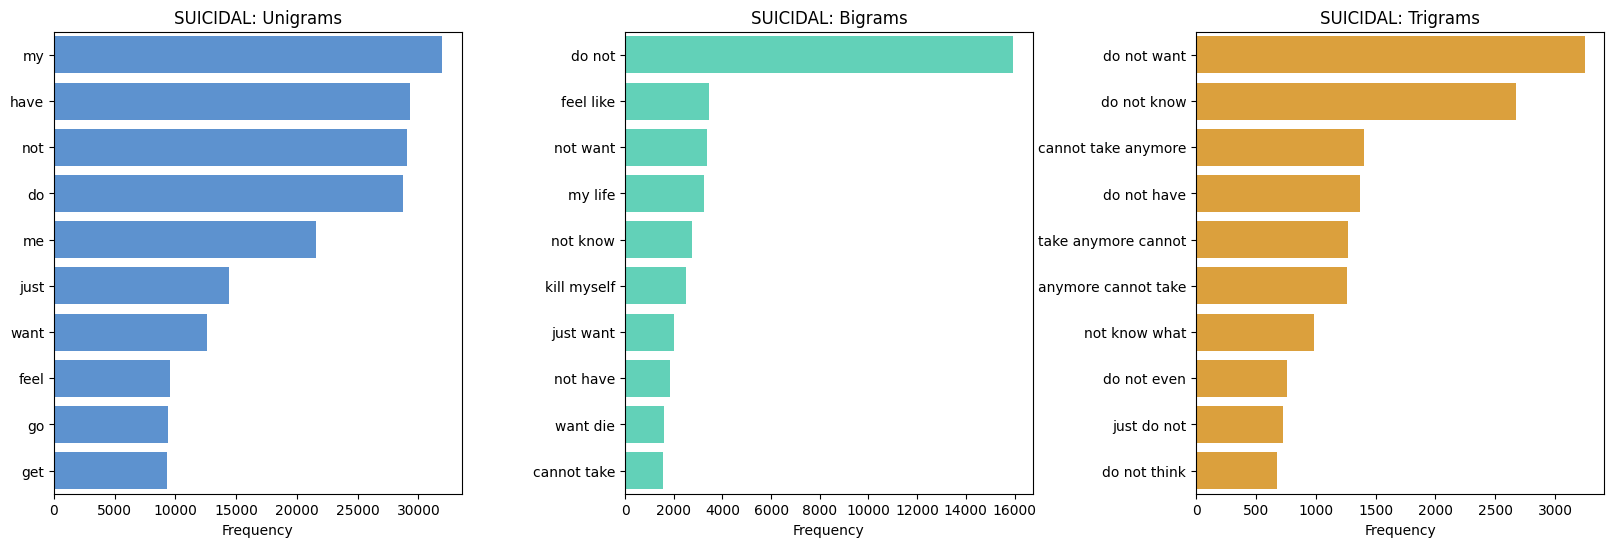

In [17]:
ngram_comparison(df, status_label="Normal")
ngram_comparison(df, status_label="Depression")
ngram_comparison(df, status_label="Suicidal")

# 4. Model Training and Hyperparameter Tuning


In [18]:
SEED = 42
MODEL_DIR = "models"
STUDY_DIR = "studies"

In [19]:
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(STUDY_DIR, exist_ok=True)

In [20]:
X = df["statement_processed"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [21]:
print(f"Total samples: {X.shape[0]}")
print(f"Total training samples: {X_train.shape[0]}")
print(f"Total testing samples: {X_test.shape[0]}")

Total samples: 41767
Total training samples: 33413
Total testing samples: 8354


## 4.1. Multinomial Naive Bayes


In [26]:
def nb_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    alpha = trial.suggest_float("nb__alpha", 1e-3, 10.0, log=True)

    fit_prior = trial.suggest_categorical("nb__fit_prior", [True, False])

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "nb",
                MultinomialNB(alpha=alpha, fit_prior=fit_prior),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )

    return score.mean()

In [27]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study_nb = optuna.create_study(direction="maximize", sampler=sampler)
study_nb.optimize(nb_objective, n_trials=30, n_jobs=1)

print(f"Best NB Score: {study_nb.best_value}")
print(f"Best NB Params :{study_nb.best_params}")

[I 2026-01-16 16:17:13,587] A new study created in memory with name: no-name-efa910b0-2adb-49dd-a62b-f1f4b83d2d6d


[I 2026-01-16 16:17:25,454] Trial 0 finished with value: 0.7703327209805036 and parameters: {'tfidf__max_features': 10500, 'tfidf__max_df': 0.9426071459614874, 'tfidf__min_df': 6, 'nb__alpha': 0.24810409748678125, 'nb__fit_prior': True}. Best is trial 0 with value: 0.7703327209805036.
[I 2026-01-16 16:17:37,173] Trial 1 finished with value: 0.7410178984195394 and parameters: {'tfidf__max_features': 5500, 'tfidf__max_df': 0.9299264218662402, 'tfidf__min_df': 5, 'nb__alpha': 0.679657809075816, 'nb__fit_prior': False}. Best is trial 0 with value: 0.7703327209805036.
[I 2026-01-16 16:17:48,751] Trial 2 finished with value: 0.7554834968604072 and parameters: {'tfidf__max_features': 17500, 'tfidf__max_df': 0.8318508666017415, 'tfidf__min_df': 3, 'nb__alpha': 0.00541524411940254, 'nb__fit_prior': False}. Best is trial 0 with value: 0.7703327209805036.
[I 2026-01-16 16:18:00,308] Trial 3 finished with value: 0.7545632123696805 and parameters: {'tfidf__max_features': 11500, 'tfidf__max_df': 0.8

Best NB Score: 0.7735491573930066
Best NB Params :{'tfidf__max_features': 18500, 'tfidf__max_df': 0.8022881020182592, 'tfidf__min_df': 7, 'nb__alpha': 0.2210018594334623, 'nb__fit_prior': True}


## 4.2. Softmax Regression (Multinomial Logistic Regression)


In [28]:
def lr_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    solver = trial.suggest_categorical("lr__solver", ["lbfgs", "saga"])
    C = trial.suggest_float("lr__C", 0.1, 10, log=True)

    penalty = "l2"
    if solver == "saga":
        penalty = trial.suggest_categorical("lr__penalty", ["l1", "l2"])

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "lr",
                LogisticRegression(
                    max_iter=5000,
                    solver=solver,
                    penalty=penalty,
                    C=C,
                    class_weight="balanced",
                    random_state=SEED,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [29]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study_lr = optuna.create_study(direction="maximize", sampler=sampler)
study_lr.optimize(lr_objective, n_trials=30, n_jobs=1)

print(f"Best LR Score: {study_lr.best_value}")
print(f"Best LR Params :{study_lr.best_params}")

[I 2026-01-16 16:35:16,946] A new study created in memory with name: no-name-fbdc97db-64e6-4817-a5fc-d90770764aa2


/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in

Best LR Score: 0.8078374120069938
Best LR Params :{'tfidf__max_features': 19000, 'tfidf__max_df': 0.947370816556896, 'tfidf__min_df': 5, 'lr__solver': 'saga', 'lr__C': 0.8616473325602313, 'lr__penalty': 'l2'}


## 4.3. Linear Support Vector Classification (Linear SVC)


In [23]:
def svc_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    C = trial.suggest_float("svc__C", 0.01, 10, log=True)

    penalty = trial.suggest_categorical("svc__penalty", ["l1", "l2"])

    if penalty == "l1":
        loss = "squared_hinge"
        dual = False
    else:
        loss = trial.suggest_categorical("svc__loss", ["hinge", "squared_hinge"])
        dual = False if loss == "squared_hinge" else True

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "svc",
                LinearSVC(
                    C=C,
                    penalty=penalty,
                    loss=loss,
                    dual=dual,
                    class_weight="balanced",
                    max_iter=5000,
                    random_state=SEED,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [25]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study_svc = optuna.create_study(direction="maximize", sampler=sampler)
study_svc.optimize(svc_objective, n_trials=30, n_jobs=1)

print(f"Best SVC Score: {study_svc.best_value}")
print(f"Best SVC Params :{study_svc.best_params}")

[I 2026-01-16 16:05:56,738] A new study created in memory with name: no-name-822ab6c4-b4eb-4cb3-8f42-feaee843ca5c
[I 2026-01-16 16:06:18,232] Trial 0 finished with value: 0.8036130054342632 and parameters: {'tfidf__max_features': 10500, 'tfidf__max_df': 0.9426071459614874, 'tfidf__min_df': 6, 'svc__C': 0.6251373574521749, 'svc__penalty': 'l1'}. Best is trial 0 with value: 0.8036130054342632.
[I 2026-01-16 16:06:35,361] Trial 1 finished with value: 0.8056917953494904 and parameters: {'tfidf__max_features': 5500, 'tfidf__max_df': 0.9299264218662402, 'tfidf__min_df': 5, 'svc__C': 1.3311216080736887, 'svc__penalty': 'l2', 'svc__loss': 'hinge'}. Best is trial 1 with value: 0.8056917953494904.
[I 2026-01-16 16:06:52,815] Trial 2 finished with value: 0.8063076195147365 and parameters: {'tfidf__max_features': 7500, 'tfidf__max_df': 0.8275106764780151, 'tfidf__min_df': 3, 'svc__C': 0.3752055855124282, 'svc__penalty': 'l1'}. Best is trial 2 with value: 0.8063076195147365.
[I 2026-01-16 16:07:08,

Best SVC Score: 0.8067319482992676
Best SVC Params :{'tfidf__max_features': 14000, 'tfidf__max_df': 0.8209240790978063, 'tfidf__min_df': 3, 'svc__C': 0.1256277350380703, 'svc__penalty': 'l2', 'svc__loss': 'squared_hinge'}


In [30]:
joblib.dump(study_nb, os.path.join(STUDY_DIR, "study_nb.pkl"))
joblib.dump(study_lr, os.path.join(STUDY_DIR, "study_lr.pkl"))
joblib.dump(study_svc, os.path.join(STUDY_DIR, "study_svc.pkl"))

['studies/study_svc.pkl']

In [31]:
nb_params = study_nb.best_params

nb_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=nb_params["tfidf__max_features"],
                max_df=nb_params["tfidf__max_df"],
                min_df=nb_params["tfidf__min_df"],
            ),
        ),
        (
            "nb",
            MultinomialNB(
                alpha=nb_params["nb__alpha"],
                fit_prior=nb_params["nb__fit_prior"],
            ),
        ),
    ]
)

nb_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('nb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [32]:
lr_params = study_lr.best_params

lr_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=lr_params["tfidf__max_features"],
                max_df=lr_params["tfidf__max_df"],
                min_df=lr_params["tfidf__min_df"],
            ),
        ),
        (
            "lr",
            LogisticRegression(
                max_iter=5000,
                solver=lr_params["lr__solver"],
                penalty=lr_params.get("lr__penalty", "l2"),
                C=lr_params["lr__C"],
                class_weight="balanced",
                random_state=SEED,
            ),
        ),
    ]
)
lr_pipeline.fit(X_train, y_train)

/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [33]:
svc_params = study_svc.best_params

svc_penalty = svc_params["svc__penalty"]
if svc_penalty == "l1":
    svc_loss = "squared_hinge"
    svc_dual = False
else:
    svc_loss = svc_params["svc__loss"]
    svc_dual = False if svc_loss == "squared_hinge" else True

svc_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=svc_params["tfidf__max_features"],
                max_df=svc_params["tfidf__max_df"],
                min_df=svc_params["tfidf__min_df"],
            ),
        ),
        (
            "svc",
            LinearSVC(
                C=svc_params["svc__C"],
                penalty=svc_penalty,
                loss=svc_loss,
                dual=svc_dual,
                class_weight="balanced",
                max_iter=5000,
                random_state=SEED,
            ),
        ),
    ]
)
svc_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [34]:
joblib.dump(nb_pipeline, os.path.join(MODEL_DIR, "nb_pipeline.pkl"))
joblib.dump(lr_pipeline, os.path.join(MODEL_DIR, "lr_pipeline.pkl"))
joblib.dump(svc_pipeline, os.path.join(MODEL_DIR, "svc_pipeline.pkl"))

['models/svc_pipeline.pkl']

# 5. Model Evaluation and Comparison


In [35]:
nb_pipeline: Pipeline = joblib.load(os.path.join(MODEL_DIR, "nb_pipeline.pkl"))
lr_pipeline: Pipeline = joblib.load(os.path.join(MODEL_DIR, "lr_pipeline.pkl"))
svc_pipeline: Pipeline = joblib.load(os.path.join(MODEL_DIR, "svc_pipeline.pkl"))

              precision    recall  f1-score   support

  Depression     0.7292    0.7416    0.7353      3018
      Normal     0.9208    0.8912    0.9058      3208
    Suicidal     0.6853    0.7021    0.6936      2128

    accuracy                         0.7890      8354
   macro avg     0.7784    0.7783    0.7782      8354
weighted avg     0.7916    0.7890    0.7901      8354



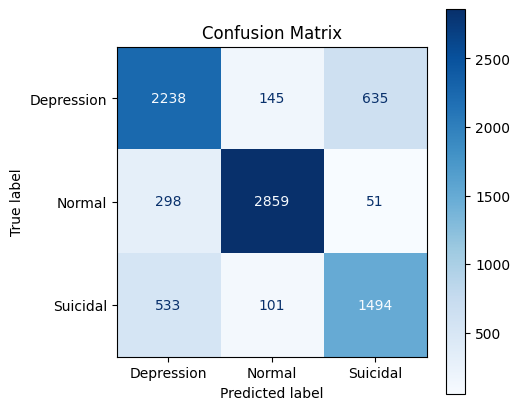

In [36]:
y_pred_nb = nb_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_nb, digits=4))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Depression     0.8218    0.7091    0.7613      3018
      Normal     0.9129    0.9638    0.9377      3208
    Suicidal     0.6818    0.7570    0.7174      2128

    accuracy                         0.8191      8354
   macro avg     0.8055    0.8100    0.8055      8354
weighted avg     0.8211    0.8191    0.8179      8354



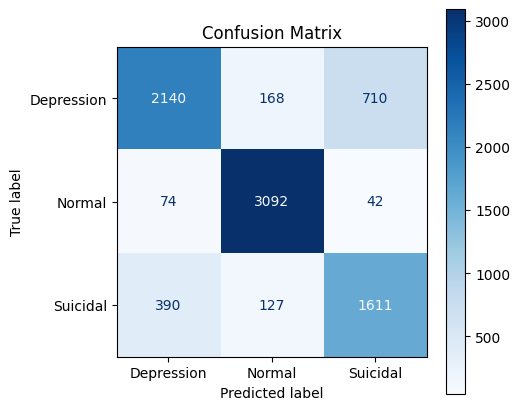

In [37]:
y_pred_lr = lr_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_lr, digits=4))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Depression     0.8147    0.7343    0.7724      3018
      Normal     0.8973    0.9754    0.9347      3208
    Suicidal     0.7028    0.7091    0.7060      2128

    accuracy                         0.8204      8354
   macro avg     0.8050    0.8063    0.8044      8354
weighted avg     0.8179    0.8204    0.8178      8354



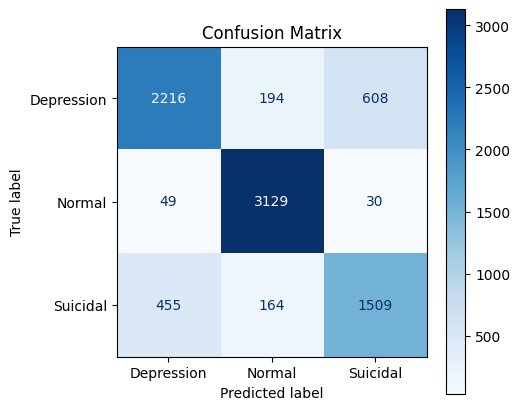

In [38]:
y_pred_svc = svc_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_svc, digits=4))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

In [39]:
logits_svc = svc_pipeline.decision_function(X_test)
y_pred_svc = svc_pipeline.predict(X_test)

feature_names = svc_pipeline.named_steps["tfidf"].get_feature_names_out()
X_test_tfidf = svc_pipeline.named_steps["tfidf"].transform(X_test)

In [40]:
random.seed(6)
idx = random.choice(range(len(X_test)))
original_text = X_test.iloc[idx] if hasattr(X_test, "iloc") else X_test[idx]

tfidf_step = svc_pipeline.named_steps["tfidf"]
analyzer = tfidf_step.build_analyzer()

tfidf_matrix = tfidf_step.transform([original_text])
vocab = tfidf_step.vocabulary_

all_tokens_in_order = analyzer(original_text)
all_tokens_in_order = sorted(set(all_tokens_in_order))
features_with_weights = [
    (t, tfidf_matrix[0, vocab[t]]) for t in all_tokens_in_order if t in vocab
]

print("Original Text:")
print(f"'{original_text}'")
print(f"\n{'Word':<15} {'TF-IDF w':<10} | {'Word':<15} {'TF-IDF w':<10}")
print("-" * 60)

midpoint = (len(features_with_weights) + 1) // 2
col1 = features_with_weights[:midpoint]
col2 = features_with_weights[midpoint:]

for i in range(midpoint):
    w1, sc1 = col1[i]

    left_side = f"{w1:<15} {sc1:<10.4f}"

    if i < len(col2):
        w2, sc2 = col2[i]
        right_side = f"| {w2:<15} {sc2:.4f}"
    else:
        right_side = "|"

    print(f"{left_side} {right_side}")

Original Text:
'i go drink vodka my forest until i fuck pas out relieve my stress . i go do very thing i swear destroy .'

Word            TF-IDF w   | Word            TF-IDF w  
------------------------------------------------------------
.               0.1192     | i swear         0.2611
. i             0.0751     | my              0.1329
. i go          0.1944     | out             0.0992
destroy         0.2200     | pas             0.2638
do              0.0682     | relieve         0.2660
drink           0.1966     | stress          0.1866
fuck            0.1324     | stress .        0.2814
go              0.1704     | swear           0.2544
go do           0.2205     | thing           0.1064
i               0.2149     | thing i         0.1616
i fuck          0.2007     | until           0.1596
i go            0.2661     | until i         0.1988
i go do         0.2475     | very            0.1401


In [41]:
random.seed(6)
idx = random.sample(range(len(X_test)), 1)[0]
text_sample = X_test.iloc[idx] if hasattr(X_test, "iloc") else X_test[idx]
ground_truth = y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx]

tfidf_step = svc_pipeline.named_steps["tfidf"]
svc = svc_pipeline.named_steps["svc"]
feature_names = tfidf_step.get_feature_names_out()
class_labels = svc.classes_

X_vec = tfidf_step.transform([text_sample])
scores = svc.decision_function(X_vec).ravel()
sorted_idx = np.invert(np.argsort(scores)).tolist()
pred_label = class_labels[sorted_idx[0]]

# Keep output compact
TOP_POS = 5
TOP_NEG = 5
TOP_MARGIN = 6
TEXT_WRAP = 90


def _rows_for_class(class_idx: int):
    nz = X_vec.nonzero()[1]
    x_vals = X_vec[0, nz].toarray().ravel()
    rows = []
    for j, x_val in zip(nz, x_vals):
        if x_val == 0:
            continue
        w = float(svc.coef_[class_idx, j])
        c = float(x_val * w)
        rows.append((feature_names[j], float(x_val), w, c))
    return rows


def _score_parts(class_idx: int):
    # score = sum_i(x_i*w_i) + b
    contrib_sum = float(X_vec.multiply(svc.coef_[class_idx]).sum())
    b = float(svc.intercept_[class_idx])
    return contrib_sum, b, contrib_sum + b


print("=" * 100)
print(textwrap.fill(f"Text: {text_sample}", width=TEXT_WRAP))
print(f"Ground truth: {ground_truth} | Predicted: {pred_label}")
print("Scores:")
print("  " + ", ".join([f"{lbl}={sc:.2f}" for lbl, sc in zip(class_labels, scores)]))
print("=" * 100)

# Predicted class breakdown (this is what your old 'Contribution' was)
for idx in sorted_idx:

    pred_label = class_labels[idx]
    rows = _rows_for_class(idx)
    pos = sorted(rows, key=lambda r: r[3], reverse=True)[:TOP_POS]
    neg = sorted(rows, key=lambda r: r[3])[:TOP_NEG]
    contrib_sum, b, total = _score_parts(idx)

    print(f"[{pred_label}] decomposition:")
    print(f"  score = sum(x_i*w_i) + b = {contrib_sum:.2f} + {b:.2f} = {total:.2f}")
    print("  Top + contributors:")
    for feat, x_val, w, c in pos:
        print(f"    {feat:<20}  tfidf={x_val:.3f}  w={w:+.2f}  contrib={c:+.2f}")
    print("  Top - contributors:")
    for feat, x_val, w, c in neg:
        print(f"    {feat:<20}  tfidf={x_val:.3f}  w={w:+.2f}  contrib={c:+.2f}")

Text: i go drink vodka my forest until i fuck pas out relieve my stress . i go do very
thing i swear destroy .
Ground truth: Suicidal | Predicted: Normal
Scores:
  Depression=-0.75, Normal=-0.77, Suicidal=0.25
[Normal] decomposition:
  score = sum(x_i*w_i) + b = -1.79 + 1.02 = -0.77
  Top + contributors:
    until                 tfidf=0.160  w=+0.22  contrib=+0.03
    very                  tfidf=0.140  w=+0.17  contrib=+0.02
    i swear               tfidf=0.261  w=+0.08  contrib=+0.02
    . i go                tfidf=0.194  w=+0.10  contrib=+0.02
    swear                 tfidf=0.254  w=+0.07  contrib=+0.02
  Top - contributors:
    i                     tfidf=0.215  w=-2.39  contrib=-0.51
    fuck                  tfidf=0.132  w=-2.46  contrib=-0.33
    i go                  tfidf=0.266  w=-0.55  contrib=-0.15
    . i                   tfidf=0.075  w=-1.86  contrib=-0.14
    relieve               tfidf=0.266  w=-0.39  contrib=-0.10
[Suicidal] decomposition:
  score = sum(x_i*w_i) + b

## 6. Case Study



 CLASS: Depression

[CORRECT PREDICTION] Text: just my thought im a 17 year male im tall lanky when i alot young maybe around 6 - 7 i use like wear short until some kid start judge how skinny i then i start feel some type way fast forward a couple year me my cousin old brother walmart my cousin decide open a bag chip leave them employee notice she come over u she didnt see our face she know 3 boy do she immediately blame me i ask my cousin why he say maybe bc your ugly i dont hate him anything bc i use get bully when i 6 - 7 about my body type my face kinda make sense fast forward 14 - 17 covid happen bad thing ever happen me i lose all my friend social skill everything i a people pleaser school i literally didnt know who i i go through a intense sadness still kinda because even my own friend use call me ugly i just brush off i start think about since i have a lot more free time shit literally ruin me like a year i use hope die my sleep after a year i gain courage talk some girl go te

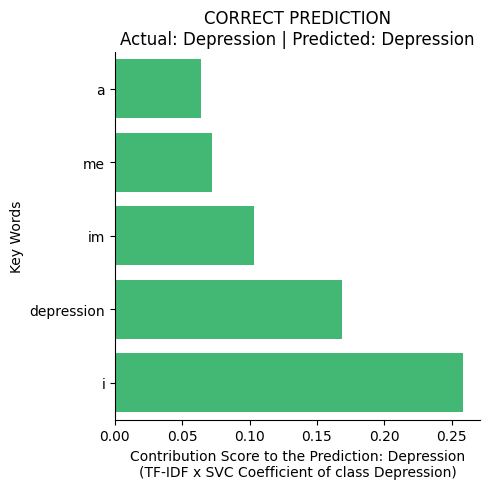


[WRONG PREDICTION] Text: you hate me , do not you ? do not hide . do not lie , i hate liar . i know you hate me , do you want know why . i lie myself all time , i hate liar . i want hurt those who others . i want hurt myself because i hurt everyone around me . how much long can i make . until i decide end all . hate


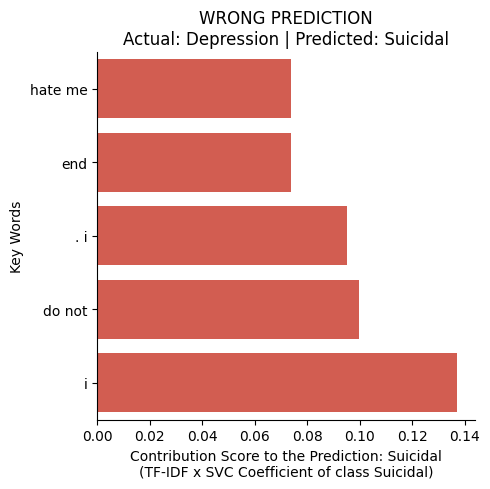


 CLASS: Normal

[CORRECT PREDICTION] Text: lissie sorry just saw post sign up even before i finish read lol these guy gold feel bad those who pay 00


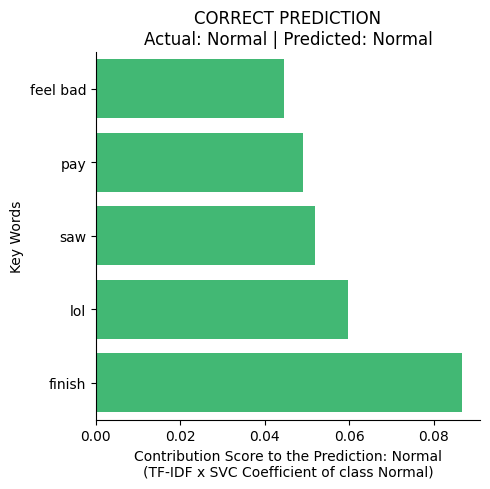


[WRONG PREDICTION] Text: if you know garret you would never have see come . family exhaust point . i just want do anything i can help them platform i have . any little thing help . i can't think a more caring family totally deserve any help they can get .


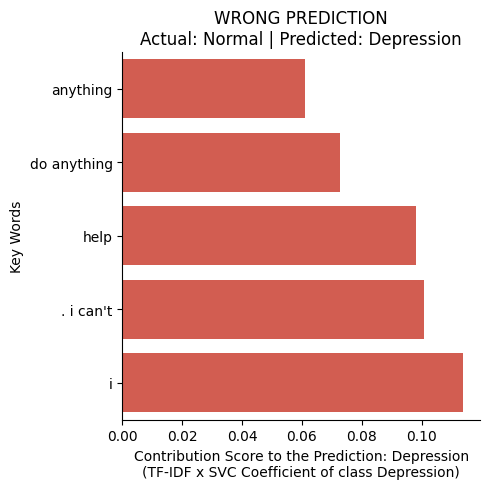


 CLASS: Suicidal

[CORRECT PREDICTION] Text: tw a brief sh mentioni'll completely alone house . i have a breakdown tonight , relapse last night . what i go do ? i struggle impulsivity . should i just get over already ? i both scared unbothered same time . i do not even know possible . i do not know what do . i wish i could just disappear not have face all . tiring .. i scar tomtorow


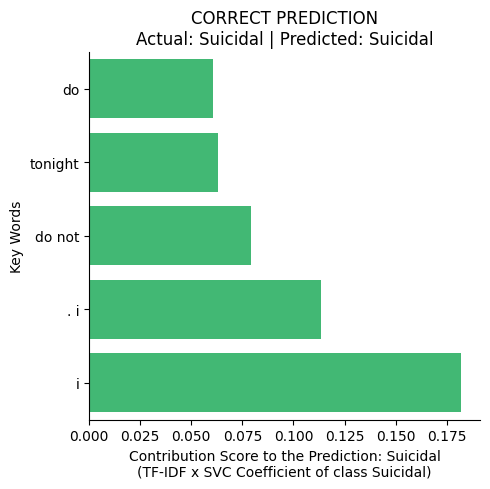


[WRONG PREDICTION] Text: year bad experience , emotional abuse , yell , bully school , isolation mental illness make me like . i believe my issue deep root i will never recover , i have therapy a while now i start take med i sick live way . i think i will never able have a normal life . i feel too damage recover


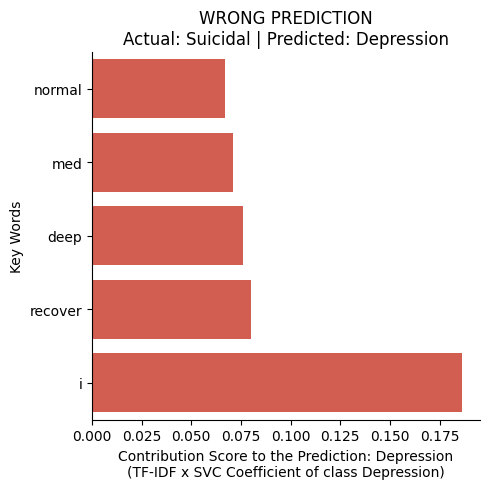

In [42]:
def plot_local_importance(pipeline, text, actual_label, pred_label, sample_type):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    x_vec = tfidf.transform([text])
    class_labels = list(svc.classes_)
    pred_idx = class_labels.index(pred_label)

    x_dense = x_vec.toarray()[0]
    weights = svc.coef_[pred_idx]
    if hasattr(weights, "toarray"):
        weights = weights.toarray()[0]
    else:
        weights = weights.flatten()

    # 3. Calculate importance
    importance = x_dense * weights
    feature_names = tfidf.get_feature_names_out()
    indices = np.argsort(importance)[-5:]
    plot_indices = [i for i in indices if importance[i] > 0]

    if not plot_indices:
        print(f"No positive contributing features found for this {sample_type}.")
        return

    values = importance[plot_indices]
    names = feature_names[plot_indices]

    plt.figure(figsize=(5, 5))
    color = "#2ecc71" if "CORRECT" in sample_type else "#e74c3c"

    sns.barplot(x=values, y=names, color=color)
    plt.title(
        f"{sample_type}\nActual: {actual_label} | Predicted: {pred_label}", fontsize=12
    )
    plt.xlabel(
        f"Contribution Score to the Prediction: {pred_label}\n(TF-IDF x SVC Coefficient of class {pred_label})",
        fontsize=10,
    )
    plt.ylabel("Key Words", fontsize=10)
    sns.despine()
    plt.tight_layout()
    plt.show()


def analyze_visual_random(pipeline, X_val, y_val):
    y_pred = pipeline.predict(X_val)
    results = pd.DataFrame({"text": X_val, "actual": y_val, "pred": y_pred})
    classes = sorted(results["actual"].unique())

    for cls in classes:
        print("\n" + "=" * 60)
        print(f" CLASS: {cls}")
        print("=" * 60)

        correct_pool = results[(results["actual"] == cls) & (results["pred"] == cls)]
        wrong_pool = results[(results["actual"] == cls) & (results["pred"] != cls)]

        samples = [
            ("CORRECT PREDICTION", correct_pool),
            ("WRONG PREDICTION", wrong_pool),
        ]

        for label, pool in samples:
            if pool.empty:
                continue

            # Select a random sample from the pool
            data = pool.sample(n=1, random_state=SEED).iloc[0]

            text_val = data["text"]
            actual_val = data["actual"]
            pred_val = data["pred"]

            print(f"\n[{label}] Text: {text_val}")
            plot_local_importance(pipeline, text_val, actual_val, pred_val, label)


analyze_visual_random(svc_pipeline, X_test, y_test)

In [43]:
svc_pipeline = joblib.load(os.path.join(MODEL_DIR, "svc_pipeline.pkl"))

Analyzing Importance for: Depression


/tmp/ipykernel_16155/2042716142.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


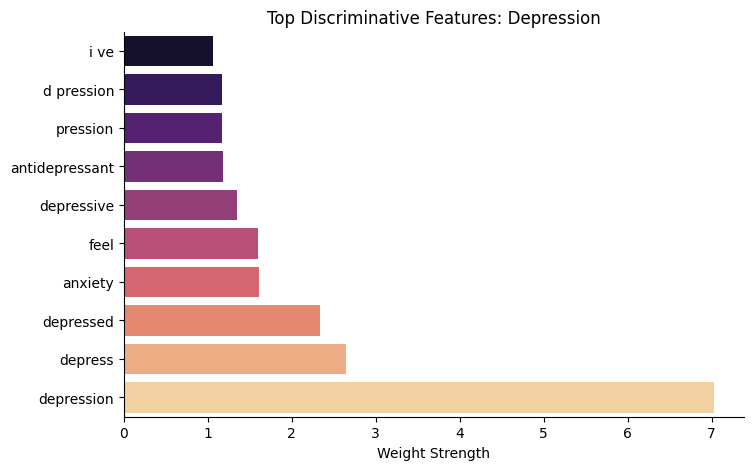

Analyzing Importance for: Normal


/tmp/ipykernel_16155/2042716142.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


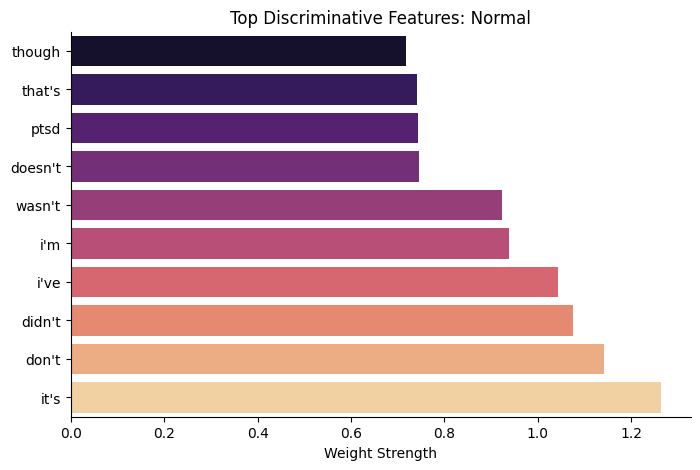

Analyzing Importance for: Suicidal


/tmp/ipykernel_16155/2042716142.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


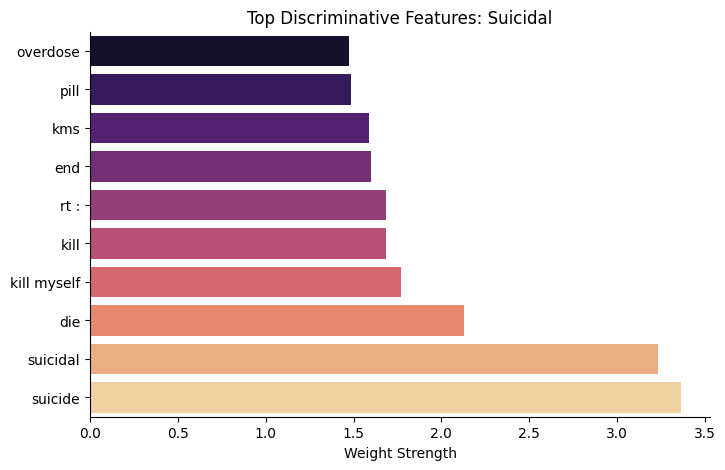

In [44]:
def plot_linear_svc_importance(pipeline, target_class, top_n=10):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    feature_names = tfidf.get_feature_names_out()
    classes = list(svc.classes_)
    target_idx = classes.index(target_class)

    # LinearSVC coef_ is (n_classes, n_features) for multi-class
    # For binary, it's (1, n_features)
    if svc.coef_.shape[0] == 1:
        weights = svc.coef_[0] if target_idx == 1 else -svc.coef_[0]
    else:
        weights = svc.coef_[target_idx]

    # Get indices of the top N weights
    indices = np.argsort(weights)[-top_n:]

    # Validation: Filter out weights that are effectively zero or negative
    # This prevents 'leaked' features from other classes showing up
    plot_indices = [i for i in indices if weights[i] > 0]

    if not plot_indices:
        print(f"No positive features found for {target_class}")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")
    plt.title(f"Top Discriminative Features: {target_class}", fontsize=12)
    plt.xlabel("Weight Strength")
    sns.despine()
    plt.show()


# Loop through all available classes (Normal, Depression, Suicidal, etc.)
for cls in svc_pipeline.named_steps["svc"].classes_:
    print(f"Analyzing Importance for: {cls}")
    plot_linear_svc_importance(svc_pipeline, cls)